In [1]:
import rasterio # for the extension to load
import xarray
import geopandas as gpd
from rasterio.windows import Window
from rasterio.plot import show
import rasterio.mask
import fiona

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def plot_raster_with_windows(raster_path, window_size=(512, 512)):
    with rasterio.open(raster_path) as src:
        num_cols = src.width
        num_rows = src.height

        for row_off in range(0, num_rows, window_size[0]):
            for col_off in range(0, num_cols, window_size[1]):
                # Define the window boundaries
                window = Window(col_off, row_off, min(window_size[1], num_cols - col_off),
                                min(window_size[0], num_rows - row_off))

                # Read the data in the window
                data = src.read(1, window=window)

                # Create the plot for the current window
                plt.imshow(data, cmap='viridis')
                plt.title(f"Window: {window.toslices()}")
                plt.colorbar()
                plt.show()

In [9]:
def plot_full_raster(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)

        # Plot the full raster using rasterio.plot.show
        #plt.figure(figsize=(10, 10))
        show(data, transform=src.transform, cmap='viridis')
        #plt.title("Full Raster")
        #plt.colorbar()
        #plt.show()

In [3]:
mountain_path = "../data/GlobalMountainsK3Binary/k1binary.tif"
mt_ds = rasterio.open(mountain_path)
plt.figure(figsize=(10, 10))
plt.imshow(mt_ds.read(1))
plt.show()

<open DatasetReader name='../data/GlobalMountainsK3Binary/k1binary.tif' mode='r'>

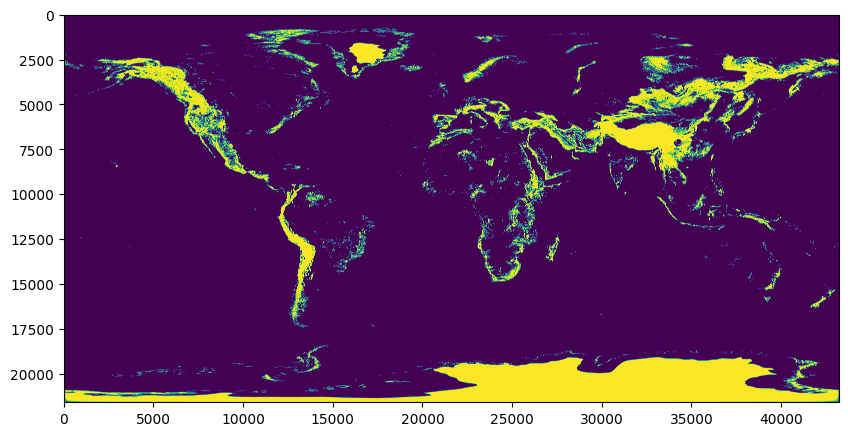

In [15]:
# Read the RiverAtlas Shapefile
dis_path = "../data/HydroRIVERS_v10_shp/reduced_HydroRIVERS_v10.shp"

dis = gpd.read_file(dis_path)

NameError: name 'df' is not defined

<Axes: >

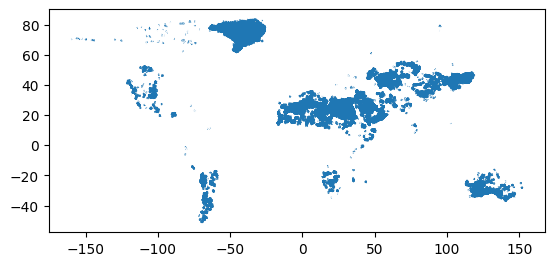

In [16]:
dis.plot()

In [18]:
with fiona.open(dis_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [21]:
with rasterio.open(mountain_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

    out_meta.update({
        "driver":"Gtiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

with rasterio.open("../output/clip_mountains.tif", 'w', **out_meta) as dst:
    dst.write(out_image)


In [23]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', dis.crs)
print('-----------------------------------------')
print('|||||||||||||||||||| Little space |||||||')
print('-----------------------------------------')
print('Imagery file Projection: ', mt_ds.crs)

Shape file Projection:  EPSG:4326
-----------------------------------------
|||||||||||||||||||| Little space |||||||
-----------------------------------------
Imagery file Projection:  EPSG:4326


<Axes: >

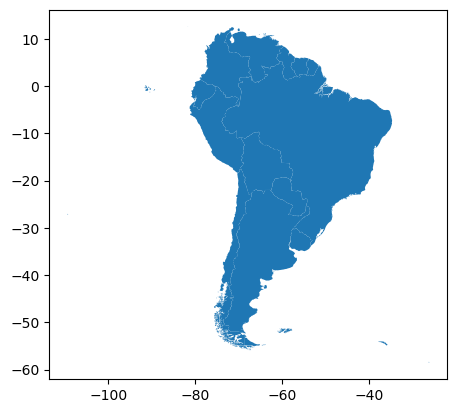

In [14]:
# Read the RiverAtlas Shapefile
sa_path = "../data/South_America/South_America.shp"

sa = gpd.read_file(sa_path)
sa.plot()

In [40]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', sa.crs)

Shape file Projection:  EPSG:4326


In [41]:
with fiona.open(sa_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

with rasterio.open(mountain_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

    out_meta.update({
        "driver":"Gtiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

with rasterio.open("../output/clip_sa.tif", 'w', **out_meta) as dst:
    dst.write(out_image)

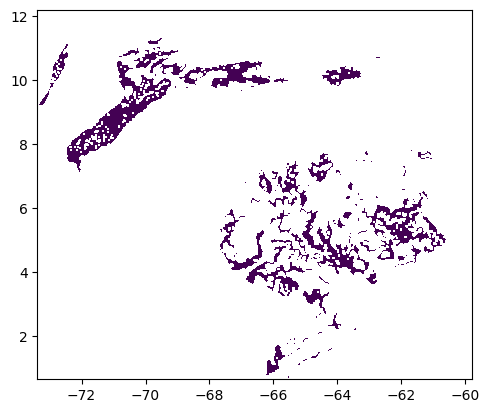

<Axes: >

In [42]:
show(rasterio.open("../output/clip_sa.tif"))

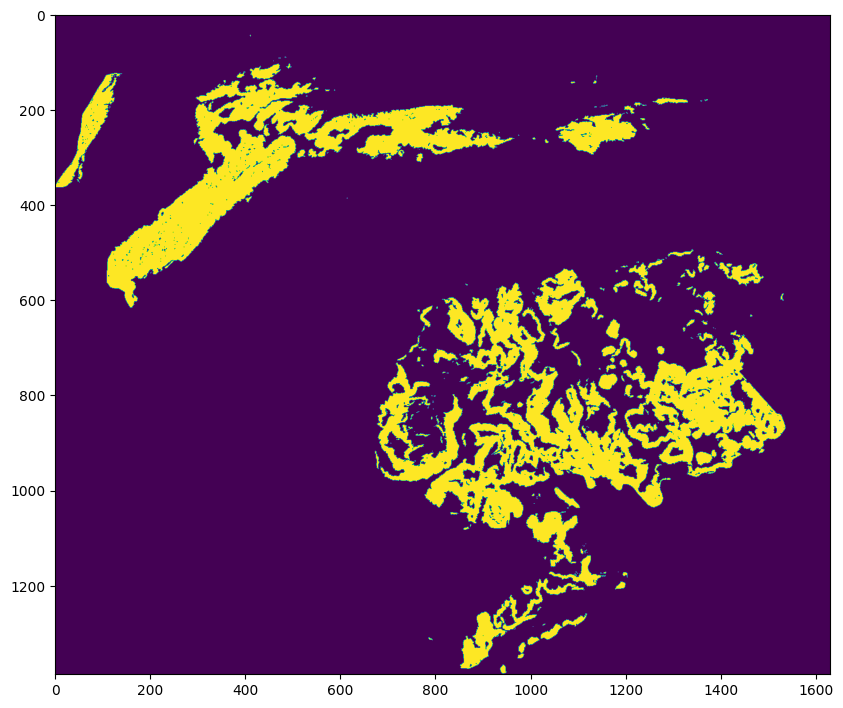

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(rasterio.open("../output/clip_sa.tif").read(1))
plt.show()

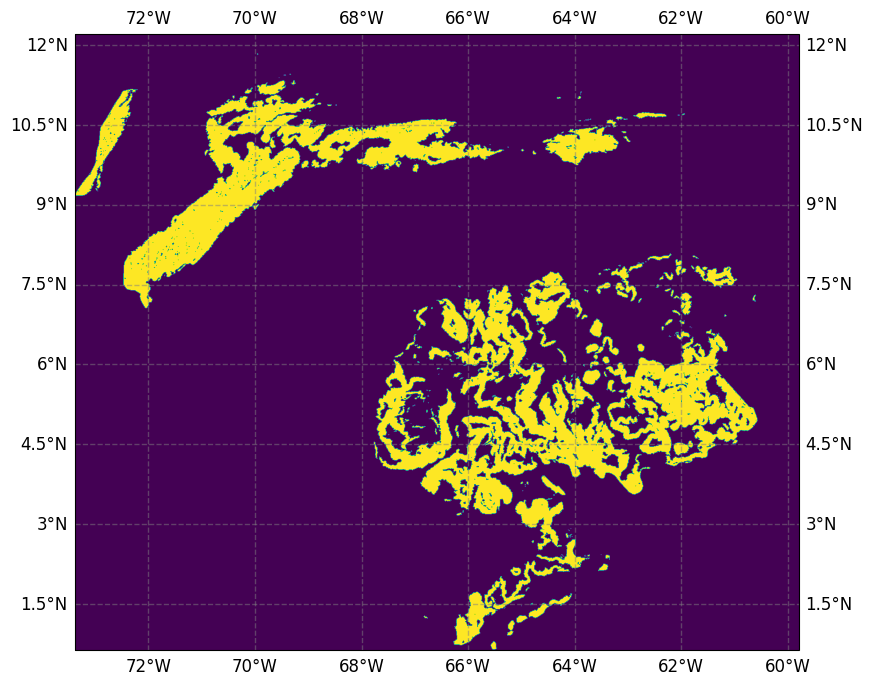

In [48]:
import rasterio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_raster_on_world_map(raster_path, world_map_image_path=None):
    def read_raster_image(raster_path):
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Assuming a single-band raster
            transform = src.transform
            bounds = src.bounds
        return raster_data, transform, bounds

    raster_data, transform, bounds = read_raster_image(raster_path)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    if world_map_image_path:
        world_map_image = plt.imread(world_map_image_path)
        ax.imshow(world_map_image, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                  transform=ccrs.PlateCarree(), origin='upper', alpha=0.5)

    ax.imshow(raster_data, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
              transform=ccrs.PlateCarree(), origin='upper', cmap='viridis')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    plt.show()

# Example usage:
raster_path = "../output/clip_sa.tif"
world_map_image_path = None
plot_raster_on_world_map(raster_path, world_map_image_path)


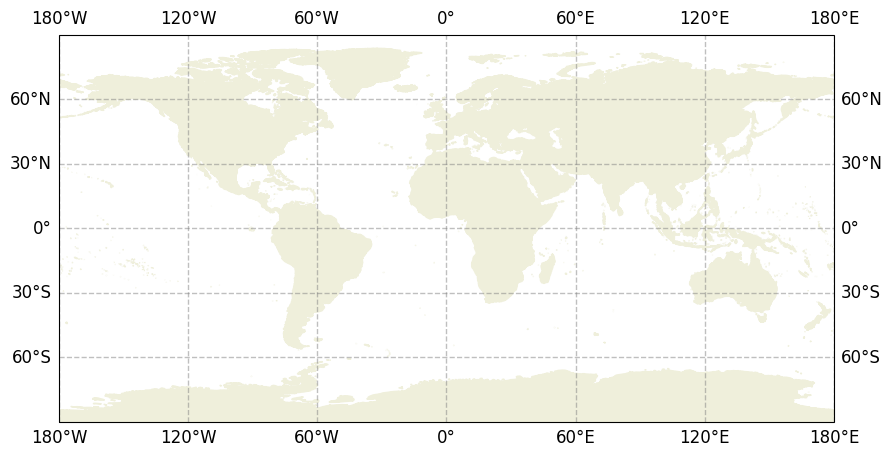

In [66]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

def plot_raster_on_world_map(raster_path):
    def read_raster_image(raster_path):
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Assuming a single-band raster
            transform = src.transform
            bounds = src.bounds
        return raster_data, transform, bounds

    raster_data, transform, bounds = read_raster_image(raster_path)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Fetch and add the Natural Earth world map as a background
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land']))

    # Plot the raster image on top of the world map
    ax.imshow(raster_data, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
              transform=ccrs.PlateCarree(), origin='upper', cmap='viridis', alpha=0.7)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    plt.show()
# Example usage:
raster_path = "../output/clip_sa_transform.tif"

plot_raster_on_world_map(raster_path)


In [60]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
# Transform projection of imagery to specific coordinate system

# Specify output projection system
dst_crs = 'EPSG:32662'

# Input imagery file name before transformation
input_imagery_file = "../output/clip_sa.tif"
# Save output imagery file name after transformation
transformed_imagery_file = "../output/clip_sa_transform.tif"

with rasterio.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rasterio.band(imagery, i),
                destination=rasterio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [67]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', rasterio.open("../output/clip_sa_transform.tif").crs)

Shape file Projection:  PROJCS["WGS 84 / Plate Carree (deprecated)",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Equirectangular"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32662"]]


In [8]:
import rioxarray
mountain_path = "../data/GlobalMountainsK3Binary/k1binary.tif"
mt_ds = rioxarray.open_rasterio(mountain_path)
mt_ds

<xarray.DataArray (band: 1, y: 21600, x: 43200)>
[933120000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.01 90.0 90.0 89.99 ... -89.96 -89.97 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  0
    STATISTICS_MAXIMUM:      1
    STATISTICS_MEAN:         1
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [9]:
dis_path = "../data/HydroRIVERS_v10_shp/raster/reduced_HydroRIVERS_v10.tif"
dis_ds = rioxarray.open_rasterio(dis_path)
dis_ds

<xarray.DataArray (band: 1, y: 1345, x: 3119)>
[4195055 values with dtype=uint64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -159.8 -159.7 -159.6 -159.5 ... 151.8 151.9 152.0
  * y            (y) float64 83.51 83.41 83.31 83.21 ... -50.69 -50.79 -50.89
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:

raster_reproject_match = mt_ds.rio.reproject_match(dis_ds)

#raster_reproject_match.plot.imshow(figsize=(8,8))

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

In [12]:
raster_reproject_match.rio.to_raster("../output/raster_clip.tif")

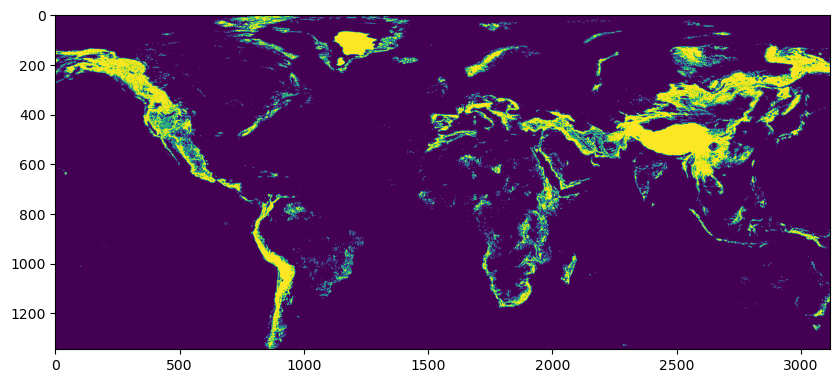

In [13]:
ds_path = "../output/raster_clip.tif"
ds = rasterio.open(ds_path)
plt.figure(figsize=(10, 10))
plt.imshow(ds.read(1))
plt.show()

In [15]:
with fiona.open(sa_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [22]:
raster_clip_fields = mt_ds.rio.clip(shapes)


In [23]:
raster_clip_fields.rio.to_raster("../output/raster_clip.tif")

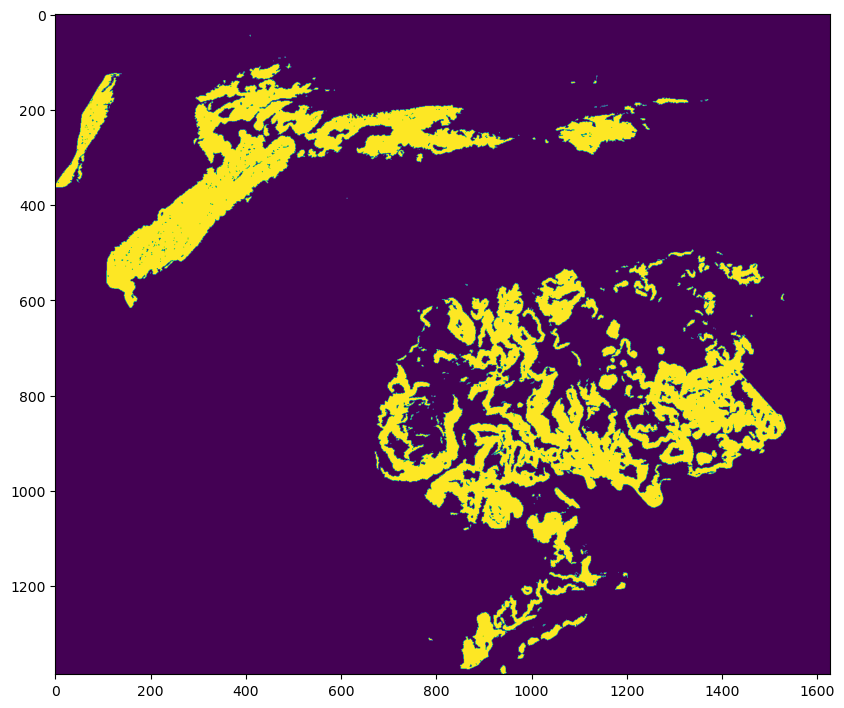

In [24]:
ds_path = "../output/raster_clip.tif"
ds = rasterio.open(ds_path)
plt.figure(figsize=(10, 10))
plt.imshow(ds.read(1))
plt.show()

In [25]:
mt_path = "../data/K3Binary/k3binary.shp"
with fiona.open(mt_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [27]:
print(shapes)

AttributeError: 'LineString' object has no attribute 'plot'

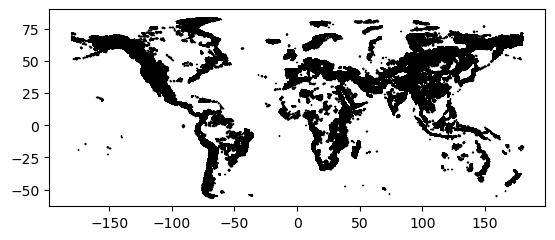

In [28]:
def extract_and_plot_first_geometry(shapefile_path):
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile_path)

    # Extract the first geometry
    first_geometry = gdf.geometry.iloc[0]

    # Plot the first geometry using geopandas
    ax = gdf.plot(edgecolor='black', facecolor='none')
    first_geometry.boundary.plot(ax=ax, color='red', linewidth=2)

    # Or, if you prefer using matplotlib directly:
    # fig, ax = plt.subplots()
    # gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    # first_geometry.boundary.plot(ax=ax, color='red', linewidth=2)

    plt.show()

# Example usage:
extract_and_plot_first_geometry(mt_path)

In [30]:
gdf = gpd.read_file(mt_path)
gdf.head()

,DN,geometry
0,1,"POLYGON ((-69.69597 83.10819, -69.69181 83.108..."
1,1,"POLYGON ((-74.28139 83.09778, -74.26889 83.097..."
2,1,"POLYGON ((-75.25639 83.03111, -75.24389 83.031..."
3,1,"POLYGON ((-75.27931 83.02486, -75.26889 83.024..."
4,1,"POLYGON ((-76.40222 83.02278, -76.39806 83.022..."


<Axes: >

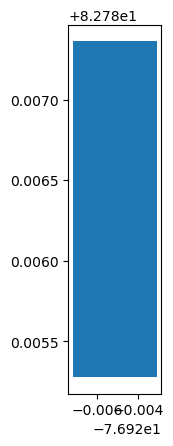

In [34]:
gdf.loc[[10],'geometry'].plot()

In [35]:
gdf.shape

(95253, 2)

In [ ]:
import geopandas as gpd

def create_intersection_shapefile(shapefile1_path, shapefile2_path, output_shapefile_path):
    # Read the input shapefiles
    gdf1 = gpd.read_file(shapefile1_path)
    gdf2 = gpd.read_file(shapefile2_path)

    # Compute the intersection between the two GeoDataFrames
    intersection_gdf = gpd.overlay(gdf1, gdf2, how='intersection')

    # Write the intersection GeoDataFrame to a new shapefile
    intersection_gdf.to_file(output_shapefile_path)

# Example usage:
shapefile1_path = "../data/K3Binary/k3binary.shp"
shapefile2_path = "../data/HydroRIVERS_v10_shp/reduced_HydroRIVERS_v10.shp"
output_shapefile_path = "../output/output_intersection.shp"

create_intersection_shapefile(shapefile1_path, shapefile2_path, output_shapefile_path)


<Axes: >

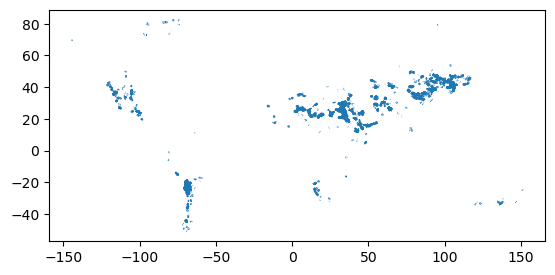

In [4]:
# Read the RiverAtlas Shapefile
dis_path = "../output/dis_mountain.shp"

dis = gpd.read_file(dis_path)
dis.plot()